<a href="https://colab.research.google.com/github/ojaashampiholi/Techpoint-Covid19/blob/dev/Scoring_%26_Maps_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

In [2]:
pip install us

In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import us
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [13]:
def getData():
    url = 'https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv?raw=true'
    df = pd.read_csv(url, parse_dates=[0])
    df = df[df['state']=='Indiana']
    df['county'] = df['county'].str.lower()
    df = df[['date', 'county', 'cases', 'deaths']]

    url2 = 'https://hub.mph.in.gov/datastore/dump/afaa225d-ac4e-4e80-9190-f6800c366b58?bom=True'  
    X = pd.read_csv(url2, parse_dates=[2])
    featureColumns = ['date', 'county_name', 'm1e_covid_tests']
    X = X[featureColumns]
    X['county_name'] = X['county_name'].str.lower()
    X = X.rename(columns={"date": "date", "county_name": "county", "m1e_covid_tests":"new test"})
    # print(X)

    combinedData = df.merge(X, on=['date', 'county'])

    counties = combinedData['county'].unique()
    dfNew = combinedData[combinedData['county']==counties[0]]
    dfNew = dfNew[-1:]
    #print(dfNew)
    for county in counties[1:]:
        df1 = combinedData[combinedData['county']==county]
        df1 = df1[-1:]
        dfNew = dfNew.append(df1, ignore_index=True)
    dfNew['cases'] = dfNew['cases']/dfNew['cases'].sum()
    dfNew['deaths'] = dfNew['deaths']/dfNew['deaths'].sum()
    dfNew['new test'] = dfNew['new test']/dfNew['new test'].sum()
    return dfNew

def getMapData():
    fp = "/content/drive/My Drive/Techpoint/tl_2010_18_county10.shp"
    map_df = gpd.read_file(fp)
    map_df['NAME10'] = map_df['NAME10'].str.lower()
    return map_df

def getMergedData():
    dfNew = getData()
    df_map = getMapData()
    merged = df_map.merge(dfNew, how='left', left_on="NAME10", right_on="county")
    merged = merged[['county', 'geometry', 'cases', 'deaths', 'new test']]
    merged['county'] = merged['county'].str.upper()
    return merged

In [16]:
def IndianaMap(merged, vars, mapColors = 'YlGn'):
    my_path = '/content/drive/My Drive/Techpoint/Indiana_Maps/'
    for var in vars:
        vmin, vmax, mapColors = merged[var].min(), merged[var].max(), 'YlGn'
        fig, ax1 = plt.subplots(1,1, figsize=(30, 17))
        merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
        merged['coords'] = [coords[0] for coords in merged['coords']]
        merged['temp'+var] = merged['county'] + '\n' + round(merged[var]*100, 4).astype(str) + '%'
        # merged['deathsText'] = merged['county'] + '\n' + round(merged[var], 4).astype(str) + '%'
        # merged['testText'] = merged['county'] + '\n' + round(merged[var], 4).astype(str) + '%'
        # print(merged)

        ax1.axis('off')
        ax1.set_title(str(var) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
        merged.plot(column=var, cmap=mapColors, linewidth=0.7, ax=ax1, edgecolor='0.5')
        for idx, row in merged.iterrows():
            ax1.annotate(s=row['temp'+var], xy=row['coords'],horizontalalignment='center', rotation=15, fontsize= '10', fontweight= '1')
        sm = plt.cm.ScalarMappable(cmap=mapColors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        fig.colorbar(sm)
        plt.savefig(my_path + str(var)+ '.png')

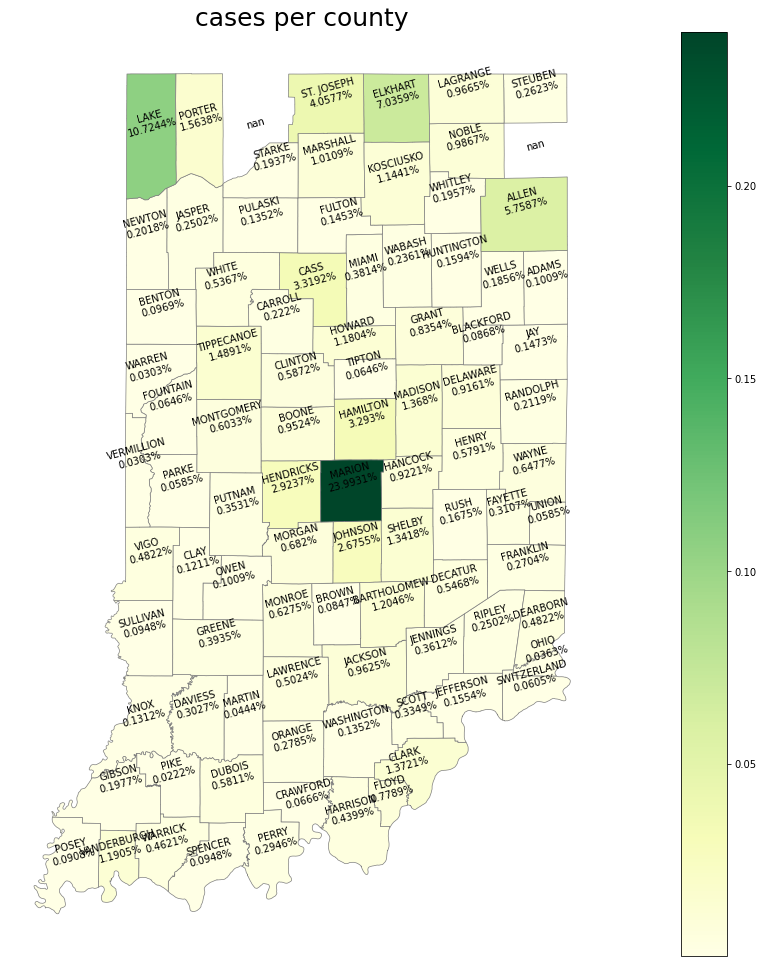

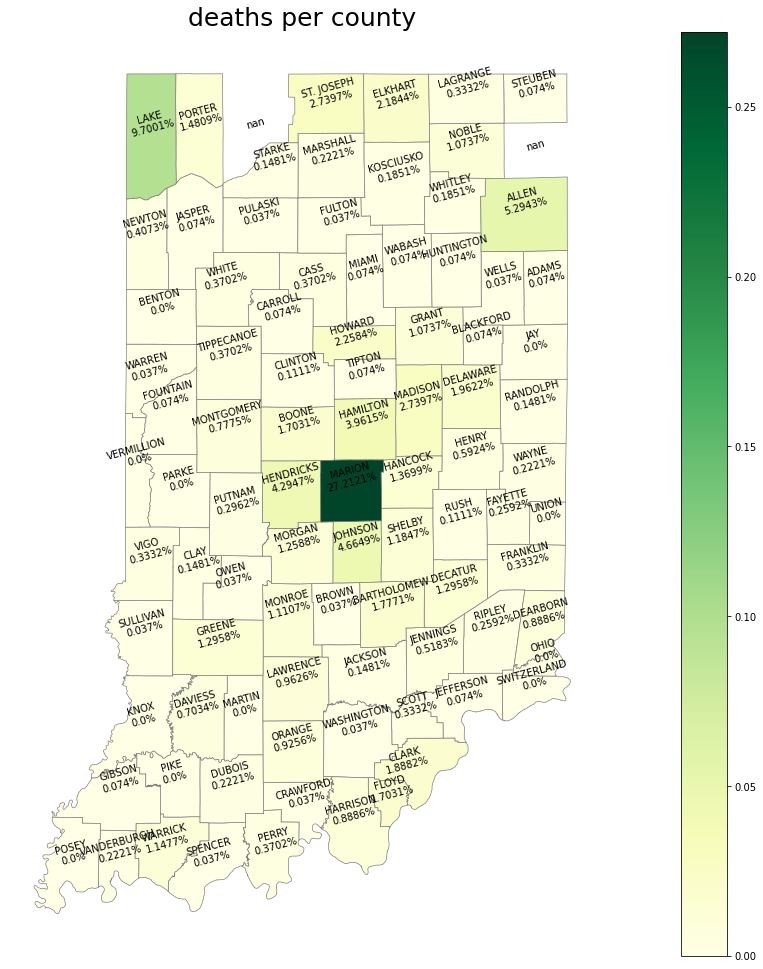

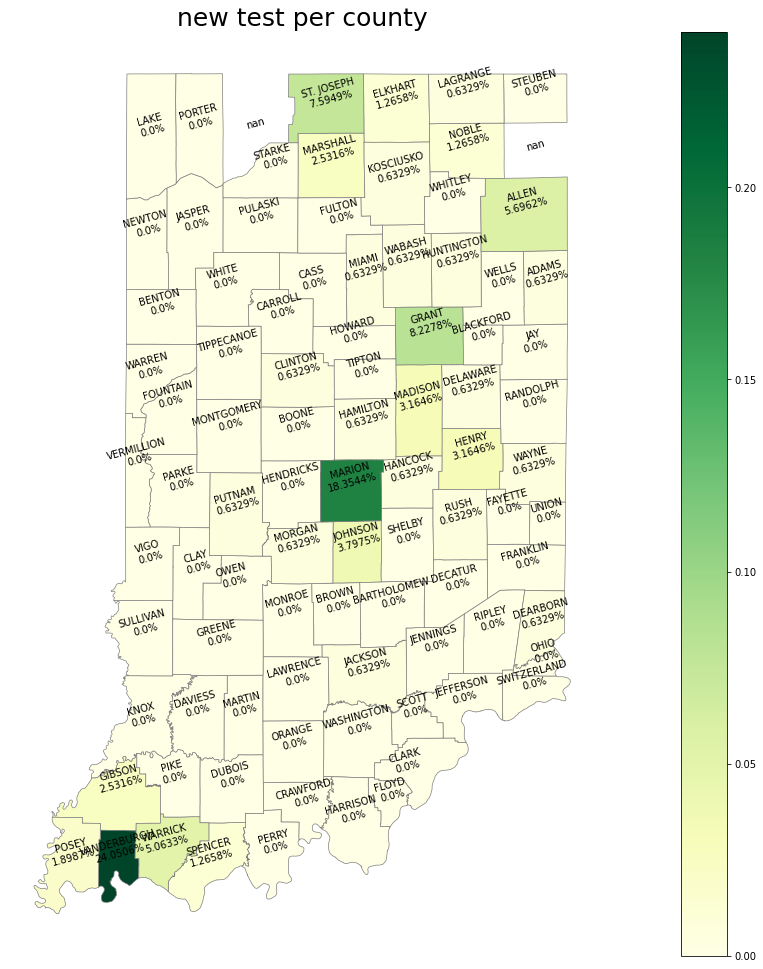

In [17]:
merged = getMergedData()
vars = ['cases', 'deaths', 'new test']
IndianaMap(merged, vars)

In [139]:
# def IndianaMap(merged, vars, mapColors = 'YlGn'):
#     my_path = '/content/drive/My Drive/Techpoint/Indiana_Maps/'
#     vmin, vmax = 0, 1
#     fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 14))
#     merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
#     merged['coords'] = [coords[0] for coords in merged['coords']]
#     merged['casesText'] = merged['county'] + '\n ' + round(merged['cases'], 4).astype(str) + '%'
#     merged['deathsText'] = merged['county'] + ' ' + round(merged['deaths'], 4).astype(str) + '%'
#     merged['testText'] = merged['county'] + ' ' + round(merged['new test'], 4).astype(str) + '%'

#     ax1.axis('off')
#     ax1.set_title(str(vars[0]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
#     merged.plot(column=vars[0], cmap=mapColors, linewidth=0.8, ax=ax1, edgecolor='0.5')
#     for idx, row in merged.iterrows():
#         ax1.annotate(s=row['casesText'], xy=row['coords'],horizontalalignment='center', rotation=10, fontsize= '9', fontweight= '1')


#     ax2.axis('off')
#     ax2.set_title(str(vars[1]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
#     merged.plot(column=vars[1], cmap=mapColors, linewidth=0.8, ax=ax2, edgecolor='0.5')
#     for idx, row in merged.iterrows():
#         ax2.annotate(s=row['deathsText'], xy=row['coords'],horizontalalignment='center', rotation=10, fontsize= '9', fontweight= '1')

#     ax3.axis('off')
#     ax3.set_title(str(vars[2]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
#     merged.plot(column=vars[2], cmap=mapColors, linewidth=0.8, ax=ax3, edgecolor='0.5')
#     for idx, row in merged.iterrows():
#         ax3.annotate(s=row['testText'], xy=row['coords'],horizontalalignment='center', rotation=10, fontsize= '9', fontweight= '1')
    
#     # sm = plt.cm.ScalarMappable(cmap=mapColors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     # fig.colorbar(sm)
#     plt.savefig(my_path + 'Indiana_Map.png')
#     # print(merged)
#     plt.show()